In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold, f_regression
from sklearn.datasets import load_boston
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# %config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
np.random.seed(42)

/Users/nelson/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nelson/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
ames_df_test = pd.read_csv('../data/ames_iowa_data_test_data_clean', index_col='Id')
X_train_sc = pd.read_csv('../pickle/X_train_sc.csv', header=None)
X_test_sc = pd.read_csv('../pickle/X_test_sc.csv', header=None)
y_train = pd.read_csv('../data/y_train.csv', header=None)
y_test = pd.read_csv('../data/y_test.csv', header=None)
X_test = pd.read_csv('../data/X_test.csv', header=None)
X_train = pd.read_csv('../data/X_train.csv', header=None)

In [3]:
ames_df_test_object = ames_df_test.select_dtypes(exclude=['int64', 'float64'])
ames_df_numeric_test = ames_df_test.select_dtypes(exclude='object')
ames_df_object_dummies_test = pd.get_dummies(ames_df_test_object, drop_first=True)
ames_features_test = pd.concat([ames_df_numeric_test, ames_df_object_dummies_test], axis=1)

In [4]:
ames_df = pd.read_csv('../data/ames_iowa_data_clean', index_col='Id')
ames_df_objects = ames_df.select_dtypes(exclude=['int64', 'float64'])
ames_df_numeric = ames_df.select_dtypes(exclude='object')
ames_df_object_dummies = pd.get_dummies(ames_df_objects, drop_first=True)
ames_features = pd.concat([ames_df_numeric, ames_df_object_dummies], axis=1)
ames_features.drop('saleprice', axis=1, inplace=True)

#### Setup the Pipeline

In [5]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold()),
    ('ss', StandardScaler()),
    #('kpercent', SelectPercentile()),
    ('kbest', SelectKBest(f_regression)),
    ('lasso', Lasso())
])

In [6]:
params = {
    'var_thresh__threshold': [0, .05],
    #'kpercent' : [20, 40, 60, 80],
    'kbest__k': [10, 20],
    'lasso__alpha': np.logspace(-3, 3, 7)
}

#### GridSearch

In [7]:
gs = GridSearchCV(pipe, params)

In [8]:
X_train.shape

(1518, 213)

In [9]:
(X_train.var() < .05).sum()

122

In [10]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x10b3cd378>)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'var_thresh__threshold': [0, 0.05], 'kbest__k': [10, 20], 'lasso__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [11]:
gs.score(X_train, y_train)

0.8157264643102389

In [12]:
gs.score(X_test, y_test)

0.8566840600943647

In [13]:
gs.best_params_

{'kbest__k': 20, 'lasso__alpha': 100.0, 'var_thresh__threshold': 0}

In [14]:
gs.best_estimator_.named_steps['var_thresh'].get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [15]:
gs.best_estimator_.named_steps['kbest'].get_support()

array([False, False, False,  True, False,  True,  True,  True,  True,
       False, False,  True,  True, False,  True, False, False,  True,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [16]:
gs.best_estimator_.named_steps['lasso'].coef_

array([ 21859.56208413,   3608.21365008,   6322.55119844,   2965.14660546,
         7014.17656534,    808.09764447,   4540.11719507,  18499.57893727,
            0.        ,   1099.88813043,   6911.19333398,   6995.21914122,
         3107.19423191,   5749.82228905, -15227.43853247, -17039.553313  ,
         2344.92657131,    663.32476681,   2054.62819762,  -3287.4549204 ])

In [17]:
columns = ames_features.columns
columns = columns[gs.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs.best_estimator_.named_steps['kbest'].get_support()]

pd.DataFrame(gs.best_estimator_.named_steps['lasso'].coef_, 
             index = columns, 
             columns=['Coef Weights'])

,Coef Weights
overall_qual,21859.562084
year_built,3608.213650
year_remod/add,6322.551198
mas_vnr_area,2965.146605
bsmtfin_sf_1,7014.176565
total_bsmt_sf,808.097644
1st_flr_sf,4540.117195
gr_liv_area,18499.578937
full_bath,0.000000
totrms_abvgrd,1099.888130


In [18]:
pred_gs = gs.predict(X_test)

In [19]:
# y_test.head()

In [20]:
# y_test[[0]].values

In [21]:
pred_gs.shape

(507,)

In [22]:
y_test.shape

(507, 1)

In [23]:
np.sqrt(mean_squared_error(y_test, pred_gs)) ## RMSE

30808.370657373966

Text(0,0.5,'Actual Values')

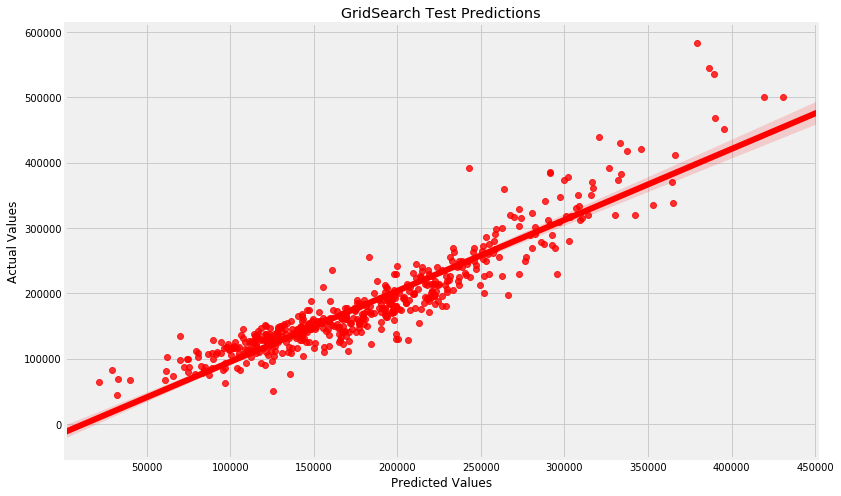

In [24]:
plt.figure(figsize=(12,8))
sns.regplot(pred_gs, y_test[0] , color='red')
plt.title("GridSearch Test Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

#### GridSearch KBest Predictions

In [25]:
diff_cols = set(ames_features.columns).difference(ames_features_test.columns)

In [26]:
for col in diff_cols:
    ames_features_test[col]=0

In [27]:
kaggle = ames_features_test[ames_features.columns]

In [28]:
pred_gs_final = gs.predict(kaggle)

In [29]:
final_gs_df = pd.DataFrame(pred_gs_final, index=kaggle.index, columns=['saleprice'])

In [30]:
final_gs_df.sort_index(inplace=True)

In [31]:
final_gs_df.to_csv('../data/gs_lasso_predictions7')